**Title:** DistilBERT Embeddings and Machine Learning Model

**Description:**

Approach Overview - DistilBERT Embeddings:
In this approach, we leveraged pre-trained DistilBERT embeddings to capture semantic representations of the review comments. DistilBERT is a lightweight version of the BERT (Bidirectional Encoder Representations from Transformers) model, which has been pre-trained on a large corpus of text data. By utilizing DistilBERT embeddings, we obtained dense vector representations for each review comment, encapsulating the contextual information within the text. These embeddings were then used as input features for training a machine learning model to predict the implicit features of the restaurant reviews.





In [1]:
# Define the mapping from categories to numerical labels
feature_mapping = {
    'food': 0,
    'service': 1,
    'price': 2,
    'ambience': 3,
    'anecdotes/miscellaneous': 4
}

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, hamming_loss, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
df = pd.read_csv('Restaurants_Train.csv', encoding='utf-8')

# Define the columns for the new DataFrame
dfcols = ['Sentence', 'Implicit Feature']
dataframe_list = []

# Loop through each row in the original DataFrame
for i, row in df.iterrows():
    category_list = []

    # Loop through each aspect category
    for j in range(4):  # Assuming 5 categories
        category = row['aspectCategories/aspectCategory/' + str(j) + '/_category']
        if pd.notna(category):
            category_list.append(category)

    # Append the processed row to the list
    dataframe_list.append([row['text'], category_list])

# Create a new DataFrame
df_csv = pd.DataFrame(dataframe_list, columns=dfcols)

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize and encode sentences
encoded_sentences = df_csv['Sentence'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Pad sequences to a fixed length
max_len = max([len(tokens) for tokens in encoded_sentences])
padded_sentences = torch.tensor([tokens + [0]*(max_len-len(tokens)) for tokens in encoded_sentences])

# Obtain DistilBERT embeddings (using CLS token)
with torch.no_grad():
  embeddings = model(padded_sentences)[0][:, 0, :]  # Use CLS token embedding

# Define features and labels
X = embeddings
y = df_csv['Implicit Feature'].apply(lambda x: [feature_mapping[category] for category in x])

# Convert labels to binary array format
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [4]:
encoded_sentences[0]

[101, 2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149, 1012, 102]

In [5]:
max_len

88

In [6]:
padded_sentences[0]

tensor([ 101, 2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149, 1012,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

In [7]:
def multi_labels_metrics(predictions, labels, threshold=0.3):
    # Convert raw predictions to binary predictions using the threshold
    binary_predictions = (predictions >= threshold).astype(int)

    f1 = f1_score(labels, binary_predictions, average='macro')
    roc_auc = roc_auc_score(labels, binary_predictions, average='macro')
    hamming = hamming_loss(labels, binary_predictions)

    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1
    }

    return metrics

def evaluate_multi_label_classifier(predictions, y_test, threshold=1):
    # Evaluate metrics
    metrics = multi_labels_metrics(predictions, y_test, threshold)

    return metrics

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type):
    if model_type == 'logistic_regression':
        model =  MultiOutputClassifier(LogisticRegression(solver='liblinear', class_weight='balanced'))
    elif model_type == 'svm':
      svm_classifier = SVC( kernel= 'linear', probability=True, class_weight='balanced')
      model = MultiOutputClassifier(svm_classifier)



    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    report = evaluate_multi_label_classifier(y_pred, y_test)
    # report = classification_report(y_test, y_pred)

    return report, model

In [8]:
# Define a dictionary to store trained models
trained_models = {}
# Initialize metrics_dict with empty dictionaries for each metric
metrics_dict = {
    'roc_auc': {},
    'hamming_loss': {},
    'f1': {}
}
# Define model types
model_types = ['logistic_regression', 'svm']
for model_type in model_types:
    print(f"\nTraining and evaluating using {model_type}:")

    # Train and evaluate the model
    report, trained_model = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type)
    print(f"Accuracy for {model_type}: {report}")

    # Store the trained model in the dictionary
    trained_models[model_type] = trained_model

    metrics_dict['roc_auc'][model_type] = report['roc_auc']
    metrics_dict['hamming_loss'][model_type] = report['hamming_loss']
    metrics_dict['f1'][model_type] = report['f1']



Training and evaluating using logistic_regression:
Accuracy for logistic_regression: {'roc_auc': 0.8554606691975278, 'hamming_loss': 0.12643678160919541, 'f1': 0.7393587573973915}

Training and evaluating using svm:
Accuracy for svm: {'roc_auc': 0.8694659493395018, 'hamming_loss': 0.11428571428571428, 'f1': 0.7632012258502676}


In [9]:
def plot_metrics(metrics_dict, experiment_names):
    metrics_names = list(metrics_dict.keys())
    num_metrics = len(metrics_names)
    num_experiments = len(experiment_names)

    # Create a grouped bar chart
    fig, ax = plt.subplots(figsize=(8, 8))
    bar_width = 0.1
    index = np.arange(num_experiments)
    opacity = 0.5

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for different experiments

    for i, metric_name in enumerate(metrics_names):
        metrics_values = [metrics_dict[metric_name][exp] for exp in experiment_names]
        ax.bar(index + i * bar_width, metrics_values, bar_width, alpha=opacity, label=metric_name, color=colors[i])

    ax.set_xlabel('Model Types')
    ax.set_ylabel('Metrics')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(index)
    ax.set_xticklabels(experiment_names)
    ax.legend()

    plt.tight_layout()
    plt.show()

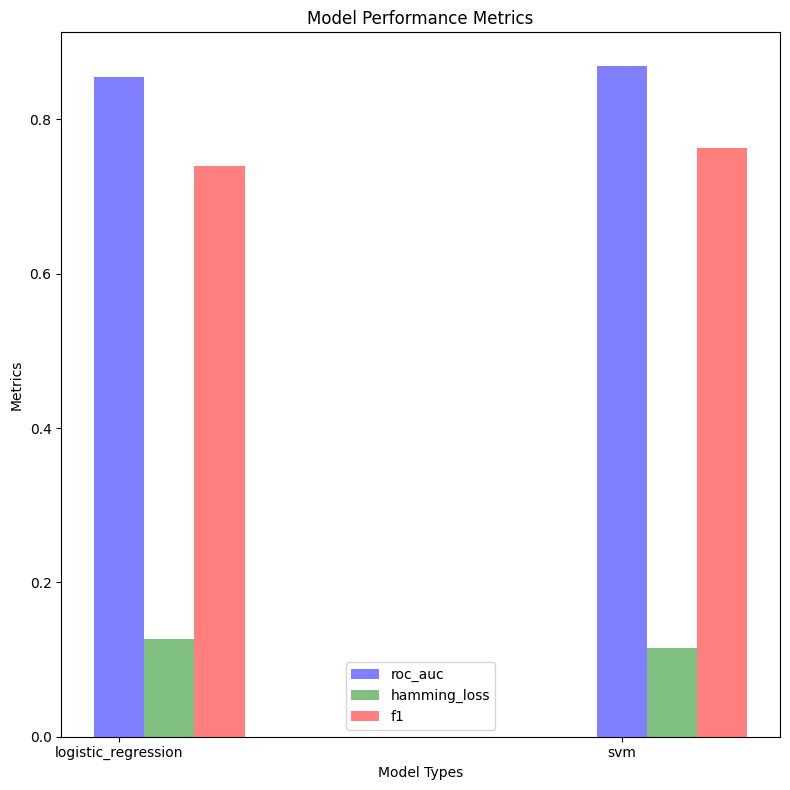

In [10]:
plot_metrics(metrics_dict, model_types)


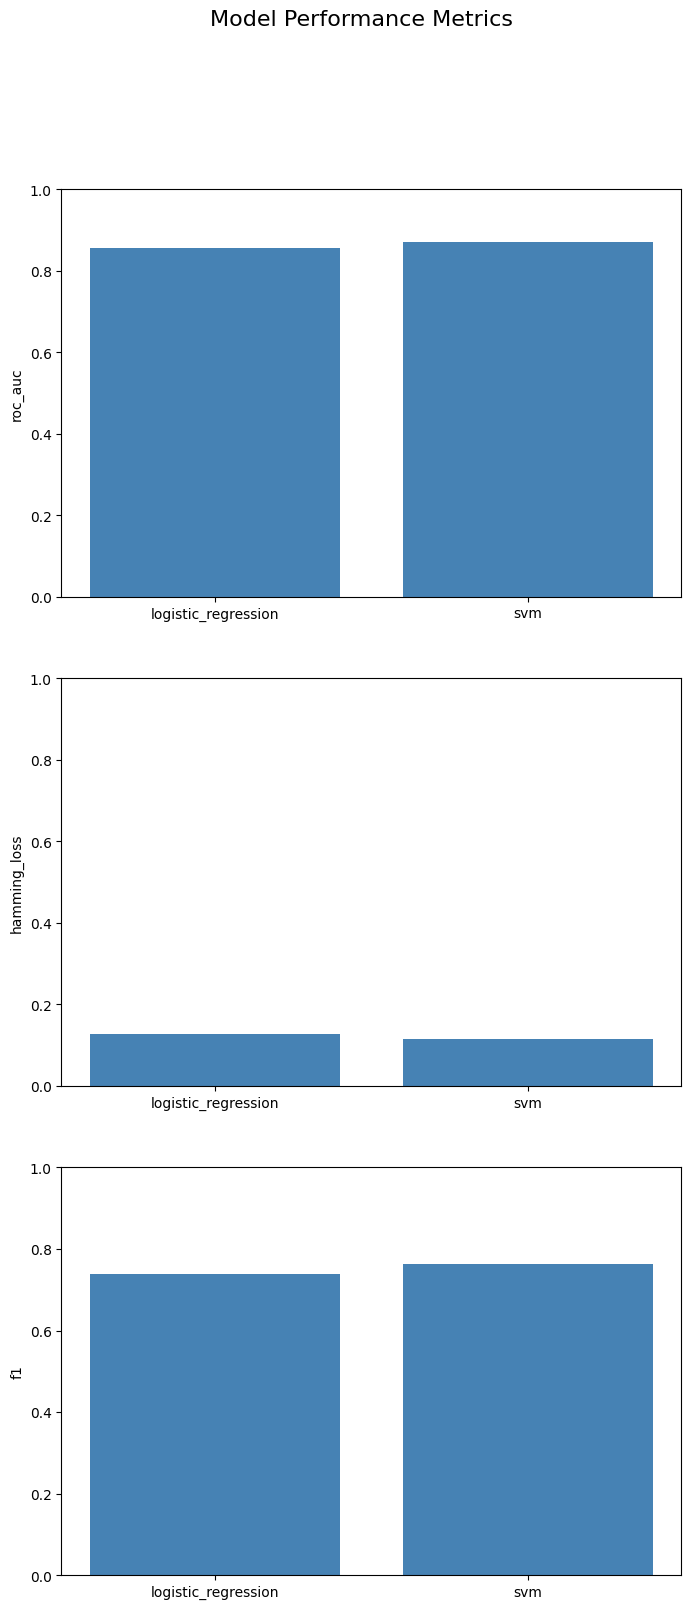

In [11]:

def plot_metrics(metrics_dict, experiment_names):
    metrics_names = list(metrics_dict.keys())
    num_metrics = len(metrics_names)
    num_experiments = len(experiment_names)

    # Create a bar chart for each metric
    fig, ax = plt.subplots(num_metrics, 1, figsize=(8, 6*num_metrics))
    fig.suptitle('Model Performance Metrics', fontsize=16)

    for i, metric_name in enumerate(metrics_names):
        ax[i].bar(experiment_names, [metrics_dict[metric_name][exp] for exp in experiment_names], color='steelblue')
        ax[i].set_ylabel(metric_name)
        ax[i].set_ylim(0, 1)  # Adjust the y-axis limits if needed

    plt.show()


plot_metrics(metrics_dict, model_types)


In [12]:
# use the trained models for making predictions on different review sentences
review_sentences = ["This restaurant has amazing food and great service, as well as high price",
                    "This place is cozy and inviting, but the food is mediocre",
                    "Lively area",
                    "staff is horrible",
                    "The flavors of the dishes were exceptional, but the prices were a bit steep, then surrounding area of hotel is welcoming"]

for model_type, _model in trained_models.items():
    print(f"\nPredictions using {model_type}:")
    for review_sentence in review_sentences:
        # Tokenization and Encoding
        encoded_review = tokenizer.encode(review_sentence, add_special_tokens=True, return_tensors='pt')

        # Obtain DistilBERT Embeddings
        with torch.no_grad():
            embeddings = model(encoded_review)[0][:, 0, :].numpy()

        # Predict Implicit Features
        predictions = _model.predict(embeddings)
        print(f"\nReview: {review_sentence}")
        print(f"Prediction: {predictions}")
        # Interpret Predictions
        # Assuming pred is the prediction vector
        for index, probability in enumerate(predictions[0]):
            if probability > 0:
                category_name = [key for key, value in feature_mapping.items() if value == index][0]
                print(f"Predicted Category: {category_name}")



Predictions using logistic_regression:

Review: This restaurant has amazing food and great service, as well as high price
Prediction: [[1 0 1 1 0]]
Predicted Category: food
Predicted Category: price
Predicted Category: ambience

Review: This place is cozy and inviting, but the food is mediocre
Prediction: [[1 0 0 1 0]]
Predicted Category: food
Predicted Category: ambience

Review: Lively area
Prediction: [[0 0 0 1 0]]
Predicted Category: ambience

Review: staff is horrible
Prediction: [[0 1 0 1 0]]
Predicted Category: service
Predicted Category: ambience

Review: The flavors of the dishes were exceptional, but the prices were a bit steep, then surrounding area of hotel is welcoming
Prediction: [[1 0 1 1 0]]
Predicted Category: food
Predicted Category: price
Predicted Category: ambience

Predictions using svm:

Review: This restaurant has amazing food and great service, as well as high price
Prediction: [[1 0 1 0 0]]
Predicted Category: food
Predicted Category: price

Review: This plac